In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.linear_model import LinearRegression
from sklearn.utils.extmath import randomized_svd
from copy import deepcopy
import causaltensor as ct
from torch.nn.modules.activation import ReLU

# -----------------------------
# 1. Simulation Settings
# -----------------------------
N, T, r = 64, 240, 2 
T2 = 20
k = 2
n_group, t_group = N//k, T//k
noise_std = 0.5
epochs = 1000
lr_model = 1e-4


class SimpleNNRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim=32):
        super(SimpleNNRegressor, self).__init__()
        self.hidden = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.output = nn.Linear(hidden_dim, 1)
        # Initialize weights similarly to our generation function
        nn.init.xavier_uniform_(self.hidden.weight)
        nn.init.xavier_uniform_(self.output.weight)
    
    def forward(self, x):
        # x: (batch_size, P)
        h = self.relu(self.hidden(x))
        out = self.output(h)
        return out

def train_simple_nn_regressor(X_train, y_train, num_epochs=1500, lr=0.001, verbose=False):
    input_dim = X_train.shape[1]
    model = SimpleNNRegressor(input_dim, hidden_dim=32)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    
    X_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_tensor = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32)
    
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        preds = model(X_tensor)
        loss = loss_fn(preds, y_tensor)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 300 == 0:
            print(f"[Simple NN] Epoch {epoch} | Loss: {loss.item():.4f}")
    return model

# -----------------------------
# 0. Setup
# -----------------------------
torch.set_default_dtype(torch.float32)
torch.manual_seed(0)
np.random.seed(0)

# -----------------------------
# 3. Autoencoder Definitions
# -----------------------------
class DisjointDecoderAE(nn.Module):
    def __init__(self, num_units, latent_dim, enc_hidden=[64,64,64], dec_hidden=[64,64,64]):
        super().__init__()
        layers, dim = [], num_units
        for h in enc_hidden:
            layers += [nn.Linear(dim,h), nn.ReLU()]; dim = h
        layers += [nn.Linear(dim, latent_dim)]
        self.encoder = nn.Sequential(*layers)
        self.decoders = nn.ModuleList([
            nn.Sequential(
                nn.Linear(latent_dim, dec_hidden[0]), nn.ReLU(),
                nn.Linear(dec_hidden[0], dec_hidden[1]), nn.ReLU(),
                nn.Linear(dec_hidden[1], 1)
            ) for _ in range(num_units)
        ])
    def forward(self, x):
        z = self.encoder(x)
        return torch.cat([d(z) for d in self.decoders], dim=1)

# -----------------------------
# 4. Train & Impute Helpers
# -----------------------------
def train_model(model, X, Y, mask, epochs=200, lr=5e-4):
    opt = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss(reduction='none')
    for _ in range(epochs):
        model.train(); opt.zero_grad()
        pred = model(X)
        loss = (loss_fn(pred, Y) * mask).sum() / mask.sum()
        loss.backward(); opt.step()
    return deepcopy(model.eval())

def impute_disjoint(model, X_sub, M_sub, units, cols):
    model.eval()
    N_sub, T_sub = X_sub.shape
    with torch.no_grad():
        Z = []
        for t in cols:
            vec = np.zeros(N_sub)
            obs = np.where(M_sub[:,t] > 0)[0]
            vec[obs] = X_sub[obs, t]
            zt = model.encoder(torch.tensor(vec, dtype=torch.float).unsqueeze(0))
            Z.append(zt)
        Z = torch.cat(Z, dim=0)
        out = [model.decoders[u](Z).squeeze(-1).cpu().numpy() for u in units]
    return np.stack(out, axis=0)

def impute_four_block_disjoint(i, j, Y_res, mask,cov_hat):
    r0, r1 = i*n_group, (i+1)*n_group
    c0, c1 = j*t_group, (j+1)*t_group
    re, ce = r1, c1

    Y_sub = Y_res[:re, :ce].copy()
    M_sub = mask[:re, :ce].copy()
    M_sub[r0:r1, c0:c1] = 0
    Y_sub[r0:r1, c0:c1] = 0

    X_tr = torch.tensor(Y_sub.T, dtype=torch.float)
    Y_tr = torch.tensor(Y_sub.T, dtype=torch.float)
    M_tr = torch.tensor(M_sub.T, dtype=torch.float)

    ae = DisjointDecoderAE(re, r)
    ae = train_model(ae, X_tr, Y_tr, M_tr, epochs, lr_model)

    block = impute_disjoint(ae, Y_sub, M_sub, np.arange(r0,r1), np.arange(c0,c1))
    return block + cov_hat[r0:r1, c0:c1]


# -----------------------------
# 5. Main Pipeline
# -----------------------------
# generate covariates & factors
control_units = np.arange(N // 2)
treated_units = np.arange(N // 2, 2*N // 2)
pre_periods = np.arange(T // 2) 
post_periods = np.arange(T // 2, 2*T // 2)

import numpy as np
import torch
import torch.nn as nn
from sklearn.linear_model import LinearRegression
from sklearn.utils.extmath import randomized_svd
from copy import deepcopy
import time
from torch.nn.parameter import Parameter
import torch.optim as optim
import random
import pandas as pd
torch.set_default_dtype(torch.float32)
from scipy import sparse
from sklearn.linear_model import Ridge
import causaltensor as ct

df1 = pd.read_csv('covid-policy-tracker-master/data/United States/OxCGRT_USA_differentiated_withnotes_2021.csv')
df2 = pd.read_csv('covid-policy-tracker-master/data/Canada/OxCGRT_CAN_differentiated_withnotes_2021.csv')
# 1. Make sure your Date column is datetime:
df1['Date'] = pd.to_datetime(df1['Date'], format='%Y%m%d')
df2['Date'] = pd.to_datetime(df2['Date'], format='%Y%m%d')
df = pd.concat([df1, df2])

# 2. Drop rows with no RegionName (if any):
df = df.dropna(subset=['RegionName'])


# 3. Pivot the policy variable into a states × dates matrix:
case_matrix = df.pivot(
    index='RegionName',
    columns='Date',
    values='ConfirmedCases'
)

d_matrix = df.pivot(
    index='RegionName',
    columns='Date',
    values='ConfirmedDeaths'
)

policy_matrix = df.pivot(
    index='RegionName',
    columns='Date',
    values='V4_Mandatory Vaccination (summary)'
)
T = T + T2
policy_matrix = policy_matrix.iloc[:, -T:-T2]
case_matrix   = case_matrix.iloc[:, -T:-T2]
d_matrix      = d_matrix.iloc[:, -T:-T2]


# 4. If there are any missing dates for a state, assume “no‐policy” (0):
policy_matrix = policy_matrix.fillna(0)

# 5. Build the mask: 1 where no policy (policy==0), 0 where policy in effect (>0):
mask_matrix = (policy_matrix == 0).astype(int)
case_matrix_0                     = case_matrix.copy()
d_matrix_0                        = d_matrix.copy()
case_matrix_0[policy_matrix == 1] = 0
d_matrix_0[policy_matrix == 1]    = 0

zero_counts    = (policy_matrix == 0).sum(axis=1)
# 2. Get the row‐index sorted by descending zero‐counts
sorted_states  = zero_counts.sort_values(ascending=False).index
sorted_states2 = zero_counts.sort_values(ascending=True).index

# 3. Reorder the DataFrame
mask_matrix   = mask_matrix.loc[sorted_states]
policy_matrix = policy_matrix.loc[sorted_states]
case_matrix_0 = case_matrix_0.loc[sorted_states]
case_matrix = case_matrix.loc[sorted_states]
d_matrix_0    = d_matrix_0.loc[sorted_states]

# 1. Grab the new state order
state_order = case_matrix_0.index
# 2. Reorder mask_matrix’s rows to match
case_matrix_obs = case_matrix.loc[state_order]
d_matrix_obs    = d_matrix.loc[state_order]

StringencyIndex_matrix = df.pivot(
    index='RegionName',
    columns='Date',
    values='StringencyIndex_NonVaccinated'
)
GovernmentResponseIndex_matrix = df.pivot(
    index='RegionName',
    columns='Date',
    values='GovernmentResponseIndex_NonVaccinated'
)
EconomicSupportIndex_matrix = df.pivot(
    index='RegionName',
    columns='Date',
    values='EconomicSupportIndex'
)
ContainmentHealthIndex_matrix = df.pivot(
    index='RegionName',
    columns='Date',
    values='ContainmentHealthIndex_WeightedAverage'
)

StringencyIndex_matrix = StringencyIndex_matrix.iloc[:, -T:-T2].loc[sorted_states].mean(axis=1).to_numpy()
GovernmentResponseIndex_matrix = GovernmentResponseIndex_matrix.iloc[:, -T:-T2].loc[sorted_states].mean(axis=1).to_numpy()
EconomicSupportIndex_matrix = EconomicSupportIndex_matrix.iloc[:, -T:-T2].loc[sorted_states].mean(axis=1).to_numpy()
ContainmentHealthIndex_matrix = ContainmentHealthIndex_matrix.iloc[:, -T:-T2].loc[sorted_states].mean(axis=1).to_numpy()
X = np.log10(np.vstack((StringencyIndex_matrix,GovernmentResponseIndex_matrix,EconomicSupportIndex_matrix,ContainmentHealthIndex_matrix)).T)

T = T - T2
Y1    = np.log10(case_matrix+0.0001).to_numpy()
Y_obs = np.log10(case_matrix+0.0001).to_numpy()

# Y1    = case_matrix.to_numpy()
# Y_obs = case_matrix.to_numpy()
# staggered treatment assignment
groups       = np.repeat(np.arange(k), n_group)
treat_starts = T - groups * t_group
ctrl0 = np.where(treat_starts >= T)[0]
mask  = mask_matrix
Y_res = Y_obs
mask  = mask.to_numpy()
Y_res = Y_res
Y_imp_disjoint = Y_obs.copy()
Y_imp_disjoint = Y_imp_disjoint

cov_hat = np.zeros((N, T))
nn_models = {}
control_units = np.arange(N // k)
treated_units = np.arange(N // k, 2*N // k)
treat_start = T // k
pre_periods = np.arange(treat_start)
post_periods = np.arange(treat_start, T)
        # For pre-treatment periods: train using all units.
for t in pre_periods:
    X_train = X.copy()       # shape: (N, P)
    y_train = Y_obs[:, t]    # (N,)
    model_t = train_simple_nn_regressor(X_train, y_train, num_epochs=400, lr=0.001, verbose=False)
    nn_models[t] = model_t
    with torch.no_grad():
        X_tensor = torch.tensor(X, dtype=torch.float32)
        preds = model_t(X_tensor).cpu().numpy().flatten()
    cov_hat[:, t] = preds
        # For post-treatment periods: use only control units.
for t in post_periods:
    X_train = X[control_units, :]
    y_train = Y_obs[control_units, t]
    model_t = train_simple_nn_regressor(X_train, y_train, num_epochs=400, lr=0.001, verbose=False)
    nn_models[t] = model_t
    with torch.no_grad():
        X_tensor = torch.tensor(X, dtype=torch.float32)
        preds = model_t(X_tensor).cpu().numpy().flatten()
    cov_hat[:, t] = preds

Y_res = Y_obs - cov_hat

for i in range(1, k):
    for j in range(k - i, k):            
        print(f"Block (row grp={i}, col grp={j})")
        r0, r1 = i*n_group, (i+1)*n_group
        c0, c1 = j*t_group, (j+1)*t_group
        re, ce = r1, c1
        Y_sub = Y_res[:re, :ce].copy()
        k1 = k-j
        k2 = k-i
        control_units = np.arange(k1*n_group)
        treated_units = np.arange(k1*n_group, re)
        pre_periods  = np.arange(k2*t_group)
        post_periods = np.arange(k2*t_group, ce)
        M_sub = mask[:re, :ce].copy()
        M_sub[treated_units[:, None], post_periods] = 0
        Y_zero_filled = Y_sub.copy()
        Y_zero_filled[M_sub == 0] = 0
        test_matrix = Y_sub.copy()
        test_matrix[treated_units[:, None], post_periods] = Y_sub[treated_units[:, None], post_periods]
        blk_d = impute_four_block_disjoint(i, j, Y_res, mask,cov_hat)
        Y_imp_disjoint[r0:r1, c0:c1] = blk_d

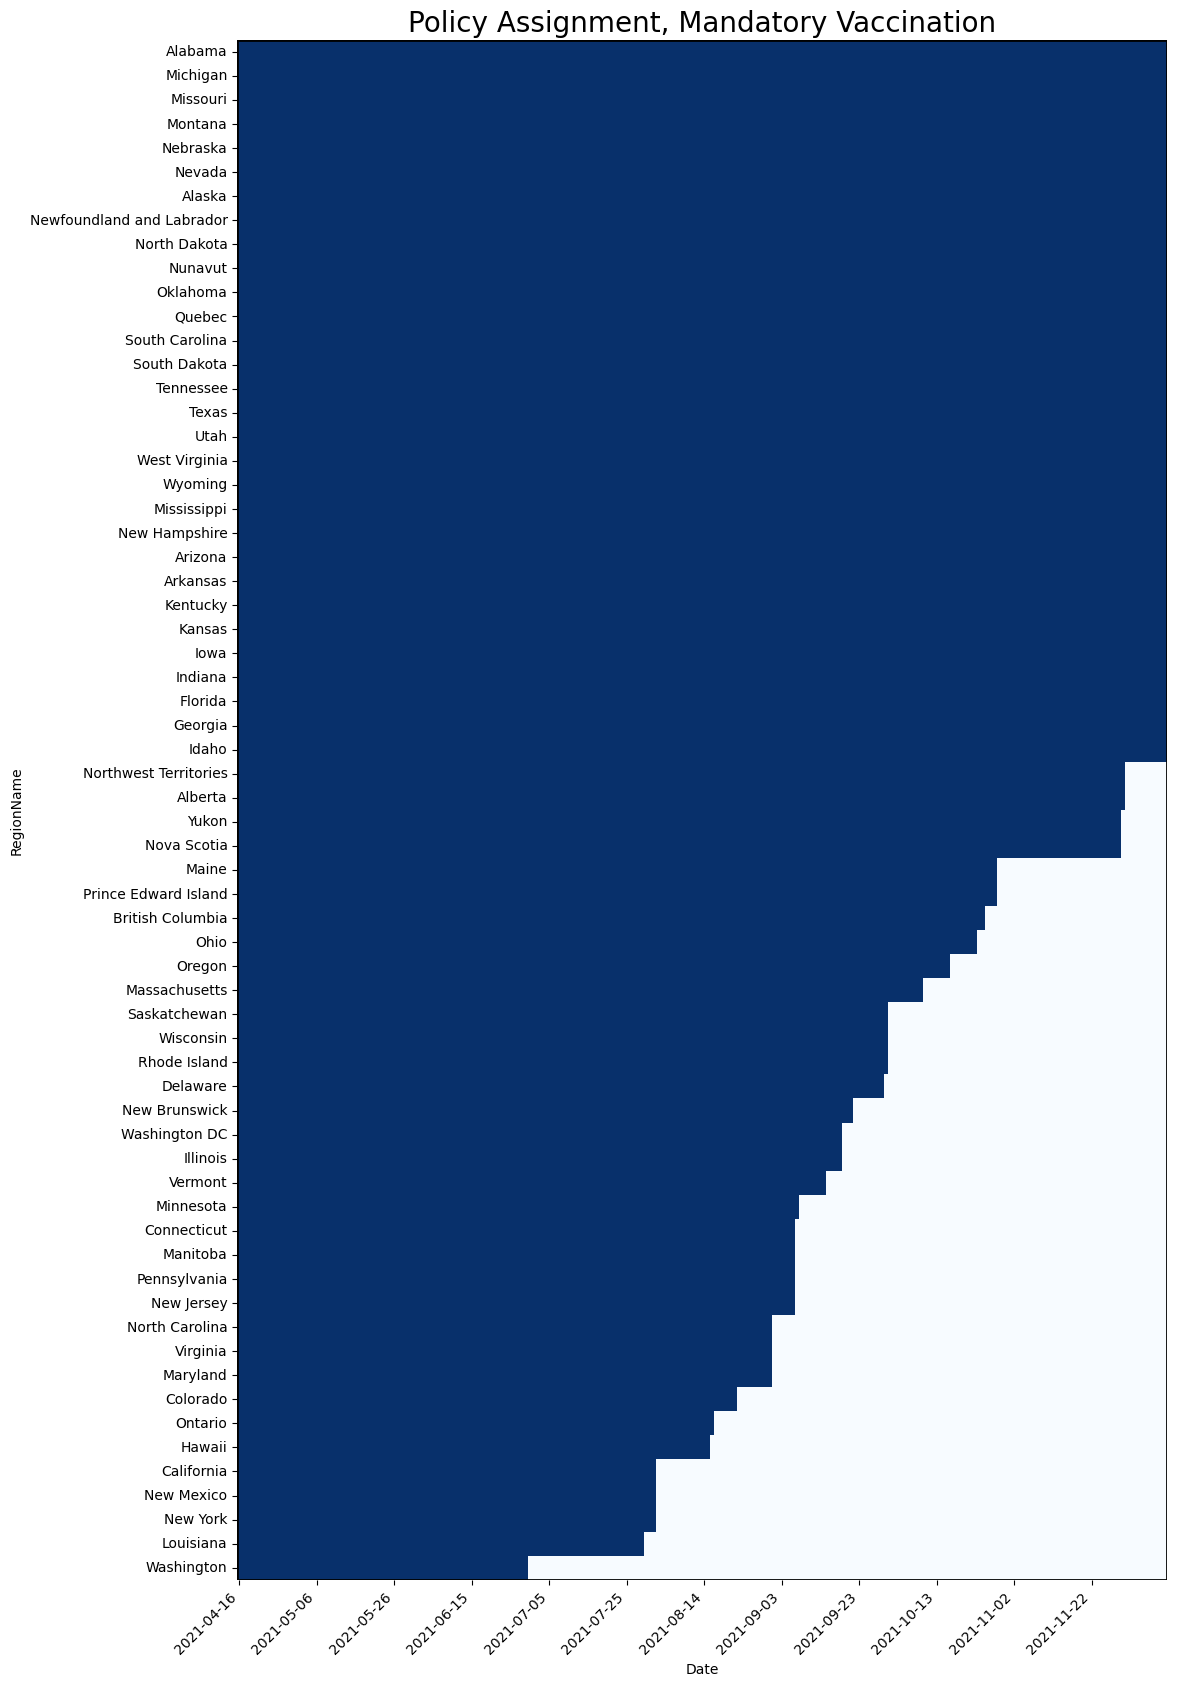

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Assume mask_matrix is already defined
T = mask_matrix.shape[1]

# Generate full time labels
full_time_labels = pd.date_range(start="2021-04-16", end="2021-12-11", periods=T)

plt.figure(figsize=(12, 20))
sns.heatmap(mask_matrix, cmap='Blues', annot=False, cbar=False)

# Find which labels to show: every ~30 days
days = pd.to_datetime(full_time_labels)
day_diff = (days[-1] - days[0]).days / T   # number of days per column
columns_per_30days = int(20 / day_diff)

# Now set xticks every `columns_per_30days`
xtick_positions = list(range(0, T, columns_per_30days))
xtick_labels = [full_time_labels[i].strftime('%Y-%m-%d') for i in xtick_positions]

# Set x-ticks
plt.xticks(ticks=[i + 0.5 for i in xtick_positions], labels=xtick_labels, rotation=45, ha='right')

# Add strong axis lines
plt.axhline(y=0, color='black', linewidth=2)
plt.axhline(y=mask_matrix.shape[0], color='black', linewidth=2)
plt.axvline(x=0, color='black', linewidth=2)
plt.axvline(x=mask_matrix.shape[1], color='black', linewidth=2)

plt.title("Policy Assignment, Mandatory Vaccination",size = 20)

plt.show()

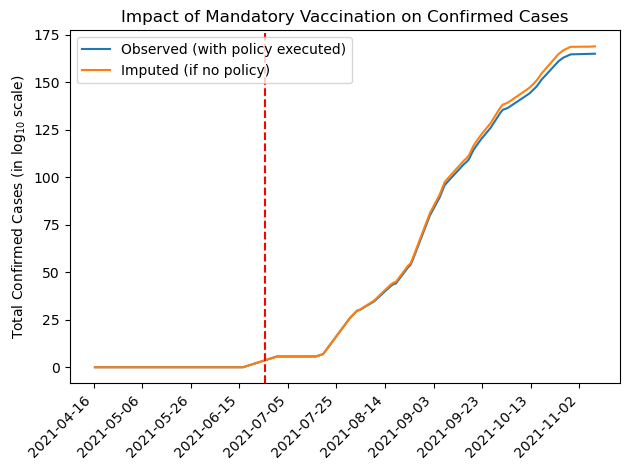

In [18]:
import numpy as np
import matplotlib.pyplot as plt

gt = []
no_policy = []

full_time_labels = pd.date_range(start="2021-04-16", end="2021-12-11", periods=T)

for i in range(240,20,-1):
    no_policy.append(sum(Y_imp_disjoint[:, -i][mask[:, -i] == 0]))
    gt.append(sum(Y_obs[:, -i][mask[:, -i] == 0]))
# assume you already have:
#   gt           = [ … ]   # your list of “ground truth” sums
#   no_policy    = [ … ]   # your list of “no policy” sums

gt_arr       = np.array(gt, dtype=float)
no_policy_arr = np.array(no_policy, dtype=float)

# choose your window size for the moving average
window = 14

# compute the simple moving averages
ma_gt        = np.convolve(gt_arr,        np.ones(window)/window, mode='valid')
ma_no_policy = np.convolve(no_policy_arr, np.ones(window)/window, mode='valid')
policy_start_idx = 70 

# Set x-ticks

# plot them
plt.figure()
plt.plot(ma_gt,        label='Observed (with policy executed)')
plt.xticks(ticks=[i -0.5 for i in xtick_positions], labels=xtick_labels, rotation=45, ha='right')
plt.plot(ma_no_policy, label='Imputed (if no policy)')
plt.axvline(x=policy_start_idx, linestyle='--', color='red')
plt.legend()
plt.ylabel('Total Confirmed Cases (in log$_{10}$ scale)')
plt.title('Impact of Mandatory Vaccination on Confirmed Cases')
plt.tight_layout()
plt.show()

In [19]:
sum(case_matrix.to_numpy()[:, -1][mask[:, -1] == 0])

26571266

In [20]:
sum_policy = 0
for i in Y_imp_disjoint[:, -1][mask[:, -1] == 0]:
    sum_policy += 10 ** i
sum_policy

29807609.050310776